In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Importing any libraries required

In [38]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import numpy as np
import librosa

Defining paths for all of the Metadata and .Wav files

In [3]:
metadata_test = "/kaggle/input/metadata/metadata of test set.csv"
metadata_train = "/kaggle/input/metadata/metadata of train set .csv"
test_data = os.path.join('/kaggle', 'input', 'test-data', 'test')
train_data = os.path.join('/kaggle', 'input', 'train-data', 'train')

In [25]:
# Extract relevant audio features
def extract_features(file_path, max_pad_len=128):
    try:
        audio, sample_rate = librosa.load(file_path, sr=32000)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
        zcr = librosa.feature.zero_crossing_rate(y=audio)
        
        # Normalize features
        mfccs = (mfccs - np.mean(mfccs)) / np.std(mfccs)
        mel_spectrogram = (mel_spectrogram - np.mean(mel_spectrogram)) / np.std(mel_spectrogram)
        spectral_centroid = (spectral_centroid - np.mean(spectral_centroid)) / np.std(spectral_centroid)
        spectral_contrast = (spectral_contrast - np.mean(spectral_contrast)) / np.std(spectral_contrast)
        zcr = (zcr - np.mean(zcr)) / np.std(zcr)
        
        # Pad/truncate features
        features = [mfccs, mel_spectrogram, spectral_centroid, spectral_contrast]
        padded_features = []
        
        for feature in features:
            pad_width = max_pad_len - feature.shape[1]
            if pad_width > 0:
                feature = np.pad(feature, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                feature = feature[:, :max_pad_len]
            padded_features.append(feature)
            
        padded_features = np.vstack(padded_features)
        return np.stack(padded_features, axis = -1)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def load_data_train(metadata_path, dataset_path):
    df = pd.read_csv(metadata_path)
    features, labels = [], []
    
    for _, row in df.iterrows():
        file_path = os.path.join(dataset_path, row["Filename"])
        feature = extract_features(file_path)
        if feature is not None:
            features.append(feature)
            labels.append(row["Class ID"])
    
    return np.array(features), np.array(labels)

def load_data_test(metadata_path, dataset_path):
    df = pd.read_csv(metadata_path)
    features, labels = [], []
    
    for _, row in df.iterrows():
        file_path = os.path.join(dataset_path, row["Filename"])
        feature = extract_features(file_path)
        if feature is not None:
            features.append(feature)
            labels.append(row["Class_id"])
    
    return np.array(features), np.array(labels)


In [45]:
test_feat, test_labels = load_data_test(metadata_test, test_data)
train_feat, train_labels = load_data_train(metadata_train, train_data)

In [46]:
print(train_feat.shape)
input_shape = train_feat.shape

(6289, 128, 176)


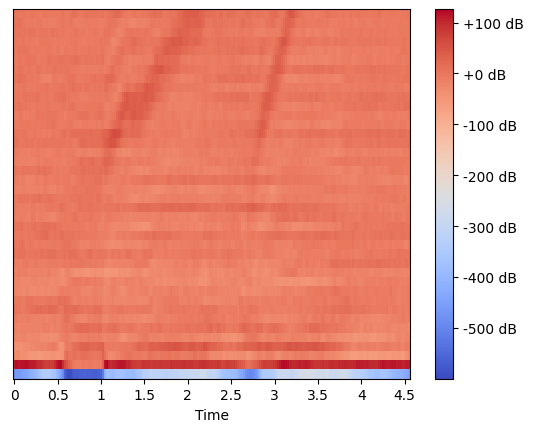

In [6]:
# y,sr = librosa.load('/kaggle/input/train-data/train/1-man yawn-aigei_6_0.wav',sr = 32000, mono = True)
# mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
# librosa.display.specshow(mfccs, x_axis= "time")
# plt.colorbar(format="%+2.0f dB")
# plt.show()

Defining a function to process all of the audio data into numerical data

# Creating Datasets

Creating static tables using tensorflow to get the data in the form a tensorflow database

In [7]:
from tensorflow.keras import datasets, layers, models

In [40]:
from sklearn.model_selection import train_test_split
train_feats, val_feats, train_label, val_label = train_test_split(train_feat, train_labels, test_size= 0.2, random_state=None, shuffle=True, stratify=None)


In [41]:
print(test_labels)
print(train_labels)
print(val_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 

In [47]:
from sklearn.model_selection import KFold

In [51]:
def create_model():
    data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),])
    
    model = models.Sequential()
    model.add(data_augmentation)
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= (128,176,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(7, activation = 'softmax'))
    
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.summary()
    return model


In [52]:
import pickle

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
model_paths = []
for train_index, val_index in kfold.split(train_feat):
    print(f'Fold {fold_no}')

    X_train, X_val = train_feat[train_index], train_feat[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    model = create_model()
        
    history = model.fit(X_train, y_train,epochs=20,batch_size=16,validation_data=(X_val, y_val),verbose=1)
        
    # Evaluate the model
    _, accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Accuracy for fold {fold_no}: {accuracy}')
    accuracies.append(accuracy)
    model_path = f'/kaggle/working/model_fold_{fold_no}.pkl'
    with open(model_path, 'wb') as file:
        pickle.dump(model, file)
    model_paths.append(model_path)
    fold_no += 1

    # Print overall results
print('------------------------------------------------------------------------')
print('Average accuracy: {:.2f} (+/- {:.2f})'.format(np.mean(accuracies), np.std(accuracies)))
print('------------------------------------------------------------------------')

Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 126, 174, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 63, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 61, 85, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 30, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 28, 40, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 71680)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │       4,587,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,643,783 (17.71 MB)

 Trainable params: 4,643,783 (17.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 337ms/step - accuracy: 0.5440 - loss: 1.2728 - val_accuracy: 0.7110 - val_loss: 0.8038
Epoch 2/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 87s 331ms/step - accuracy: 0.7658 - loss: 0.6642 - val_accuracy: 0.7411 - val_loss: 0.7599
Epoch 3/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 143s 336ms/step - accuracy: 0.8986 - loss: 0.3162 - val_accuracy: 0.7272 - val_loss: 0.9048
Epoch 4/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 88s 336ms/step - accuracy: 0.9474 - loss: 0.1565 - val_accuracy: 0.7387 - val_loss: 1.2053
Epoch 5/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 142s 335ms/step - accuracy: 0.9634 - loss: 0.1034 - val_accuracy: 0.7320 - val_loss: 1.0608
Epoch 6/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 87s 333ms/step - accuracy: 0.9770 - loss: 0.0695 - val_accuracy: 0.7353 - val_loss: 1.6307
Epoch 7/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 88s 335ms/step - accuracy: 0.9848 - loss: 0.0540 - val_accuracy: 0.7296 - val_loss: 1.7031
Epoch 8/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 88s 335ms/step - accuracy: 0.9836 - loss: 0.0479 - v

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 126, 174, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 63, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 61, 85, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 30, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 28, 40, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 71680)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │       4,587,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,643,783 (17.71 MB)

 Trainable params: 4,643,783 (17.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 90s 335ms/step - accuracy: 0.5805 - loss: 1.1444 - val_accuracy: 0.7047 - val_loss: 0.8004
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 86s 329ms/step - accuracy: 0.7776 - loss: 0.6135 - val_accuracy: 0.7185 - val_loss: 0.8324
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 143s 332ms/step - accuracy: 0.8844 - loss: 0.3348 - val_accuracy: 0.7376 - val_loss: 0.9805
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 87s 331ms/step - accuracy: 0.9364 - loss: 0.1814 - val_accuracy: 0.6966 - val_loss: 1.3107
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 334ms/step - accuracy: 0.9510 - loss: 0.1434 - val_accuracy: 0.7252 - val_loss: 1.3376
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 98s 373ms/step - accuracy: 0.9755 - loss: 0.0996 - val_accuracy: 0.7261 - val_loss: 1.5064
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 334ms/step - accuracy: 0.9774 - loss: 0.0714 - val_accuracy: 0.7261 - val_loss: 1.5724
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 87s 331ms/step - accuracy: 0.9937 - loss: 

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)                   │ (None, 126, 174, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 63, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 61, 85, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 30, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 28, 40, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 71680)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │       4,587,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,643,783 (17.71 MB)

 Trainable params: 4,643,783 (17.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 87s 326ms/step - accuracy: 0.5334 - loss: 1.2822 - val_accuracy: 0.7004 - val_loss: 0.8378
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 85s 322ms/step - accuracy: 0.7759 - loss: 0.6273 - val_accuracy: 0.7094 - val_loss: 0.9007
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 143s 325ms/step - accuracy: 0.8768 - loss: 0.3413 - val_accuracy: 0.7328 - val_loss: 1.0311
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 86s 325ms/step - accuracy: 0.9396 - loss: 0.1726 - val_accuracy: 0.7323 - val_loss: 1.1078
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 84s 320ms/step - accuracy: 0.9701 - loss: 0.0920 - val_accuracy: 0.7242 - val_loss: 1.3552
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 85s 322ms/step - accuracy: 0.9626 - loss: 0.1193 - val_accuracy: 0.7443 - val_loss: 1.5298
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 142s 322ms/step - accuracy: 0.9772 - loss: 0.0750 - val_accuracy: 0.7295 - val_loss: 1.8321
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 85s 323ms/step - accuracy: 0.9883 - loss:

In [32]:
#history = model.fit(train_feat, train_labels, epochs=10, validation_data=(val_feat, val_labels))

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 151s 758ms/step - accuracy: 0.5802 - loss: 1.1825 - val_accuracy: 0.5793 - val_loss: 1.1634
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 128s 649ms/step - accuracy: 0.7997 - loss: 0.5684 - val_accuracy: 0.6800 - val_loss: 0.9409
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 130s 659ms/step - accuracy: 0.8957 - loss: 0.2989 - val_accuracy: 0.6524 - val_loss: 1.1181
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 130s 660ms/step - accuracy: 0.9489 - loss: 0.1692 - val_accuracy: 0.6566 - val_loss: 1.6106
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 143s 727ms/step - accuracy: 0.9611 - loss: 0.1301 - val_accuracy: 0.6745 - val_loss: 1.5846
Epoch 6/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 188s 657ms/step - accuracy: 0.9758 - loss: 0.0731 - val_accuracy: 0.6690 - val_loss: 1.9583
Epoch 7/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 130s 658ms/step - accuracy: 0.9815 - loss: 0.0603 - val_accuracy: 0.6855 - val_loss: 1.9718
Epoch 8/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 127s 642ms/step - accuracy: 

KeyboardInterrupt: 

In [57]:
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_feat,  test_labels, verbose=2)

23/23 - 4s - 167ms/step - accuracy: 0.6055 - loss: 3.9693


In [61]:
model_paths = ['/kaggle/input/model/tensorflow1/default/1/model_fold_1.pkl', '/kaggle/input/model/tensorflow1/default/1/model_fold_2.pkl','/kaggle/input/model/tensorflow1/default/1/model_fold_3.pkl']
test_accuracies = []
for i, model_path in enumerate(model_paths, 1):
    with open(model_path, 'rb') as file:  
        model = pickle.load(file)
    loss, accuracy = model.evaluate(test_feat, test_labels, verbose=0)
    print(f'Model {i} - Test accuracy: {accuracy:.4f}')
    test_accuracies.append(accuracy)
    
print('------------------------------------------------------------------------')
print('Average test accuracy: {:.4f} (+/- {:.4f})'.format(np.mean(test_accuracies), np.std(test_accuracies)))
print('------------------------------------------------------------------------')

Model 1 - Test accuracy: 0.6814
Model 2 - Test accuracy: 0.6276
Model 3 - Test accuracy: 0.6055
------------------------------------------------------------------------
Average test accuracy: 0.6382 (+/- 0.0319)
------------------------------------------------------------------------
